In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import sys

base_path = ".."
sys.path.append(f"{base_path}")
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib
import matplotlib as mpl
from itertools import combinations
from tqdm import tqdm

from utils.gnn_utils import *
from utils.utils import *

In [65]:
experiment_name = "experiment_mouse_st"
sc_path = "../data/single-cell/Allenbrain_forSimulation_uniquect.h5ad"
st_path = "../data/spatial/V1_Mouse_Brain_Sagittal_Anterior.h5ad"

# experiment_name = "experiment_kidney_slideSeq_v2_105"
# # sc_path = "../data/single-cell/kidney_slideSeq_v2_105.h5ad"
# st_path = (
#     "../data/spatial/simulations_kidney_slideSeq_v2/UMOD-KI.KI-4b_resolution105.h5ad"
# )

In [66]:
experiment_dir = f"{base_path}/experiments"
experiment_path = f"{experiment_dir}/{experiment_name}"

In [67]:
# sc_data = sc.read_h5ad(sc_path)

st_data, X_real, X_real_train, X_sim, y_sim = load_data(
    st_path=st_path,
    gene_expr_path=f"{experiment_path}/datasets",
)
y_real = st_data.obs[st_data.obs.columns[2::]].to_numpy()
y_real = st_data.obs[st_data.obs.columns[2::]]

/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Analyze relationship between gene expression similarity and spatial distance

### Fist use celltype composition as proxy for gene expression similarity

In [7]:
st_data

AnnData object with n_obs × n_vars = 1803 × 18961
    obs: 'row', 'col', 'blood vessel smooth muscle cell', 'endothelial cell', 'kidney collecting duct intercalated cell', 'kidney collecting duct principal cell', 'kidney distal convoluted tubule epithelial cell', 'kidney interstitial fibroblast', 'kidney loop of Henle thick ascending limb epithelial cell', 'kidney proximal convoluted tubule epithelial cell', 'leukocyte', 'macrophage', 'mesangial cell', 'podocyte'
    uns: 'spatial'
    obsm: 'spatial'

In [68]:
coords = normalize_coords(st_data.obsm["spatial"])

In [20]:
celltype_abundances = st_data.obs[st_data.obs.columns[2::]].to_numpy()

In [69]:
dist_mat = scipy.spatial.distance_matrix(coords, coords)

In [28]:
celltype_distances = scipy.spatial.distance_matrix(celltype_abundances, celltype_abundances)

In [35]:
celltype_distances = []
for vec_1 in tqdm(celltype_abundances):
    for vec_2 in celltype_abundances:
        dist = scipy.spatial.distance.jensenshannon(vec_1, vec_2)
        celltype_distances.append(dist)

In [39]:
# analyze correlation between celltype distance and euclidean distance
result = scipy.stats.pearsonr(dist_mat.flatten(), celltype_distances.flatten())

### Consider the full expression profile

In [70]:
sc.pp.filter_genes(st_data, min_cells=10)

/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [71]:
st_data

AnnData object with n_obs × n_vars = 2695 × 17103
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [72]:
sc.pp.normalize_total(st_data, target_sum=1e4)
sc.pp.log1p(st_data)

In [73]:
# maybe scale the data
# sc.pp.scale(st_data, max_value=10)
sc.tl.pca(st_data, n_comps=50)

In [74]:
pca_embeddings = st_data.obsm["X_pca"]
gene_expr_distances = scipy.spatial.distance_matrix(pca_embeddings, pca_embeddings)

In [75]:
# analyze correlation between celltype distance and euclidean distance
corr, pval = scipy.stats.pearsonr(dist_mat.flatten(), gene_expr_distances.flatten())

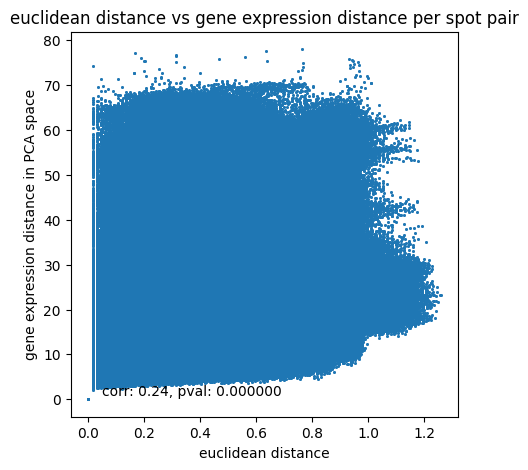

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(dist_mat.flatten(), gene_expr_distances.flatten(), s=1)
ax.set_xlabel("euclidean distance")
ax.set_ylabel("gene expression distance in PCA space")
plt.title("euclidean distance vs gene expression distance per spot pair")
# show corr and pval as text
ax.text(
    0.05,
    0.95,
    f"corr: {corr:.2f}, pval: {pval:.6f}",
)

plt.savefig(f"{base_path}/figures/euclidean_vs_gene_expr_distance_{experiment_name}.png", dpi=300, bbox_inches="tight")
plt.show()
